In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [19]:
agilent = pd.read_csv('../cnv_data/NA12878.WES.agilent_v5.hg38.binned_coverage.bed', sep='\t', header=None, names=['chr', 'start', 'end', 'depth'], index_col=None)
ice = pd.read_csv('../cnv_data/NA12878.WES.ice.hg38.binned_coverage.chr1.bed', sep='\t', header=None, names=['chr', 'start', 'end','depth'])
twist = pd.read_csv('../cnv_data/NA12878.WES.twist.hg38.binned_coverage.chr1.bed', sep='\t', header=None, names=['chr', 'start', 'end','depth'])
unknown = pd.read_csv('../cnv_data/NA12878.WES.unknown_v1.hg38.binned_coverage.chr1.bed', sep='\t', header=None, names=['chr', 'start', 'end','depth'])


In [20]:
phase1_2 = pd.read_csv('../cnv_data/NA12878.WES.phase1_2.hg38.binned_coverage.chr1.bed', sep='\t', header=None, names=['chr', 'start', 'end','depth'])
phase3 = pd.read_csv('../cnv_data/NA12878.WES.phase3.hg38.binned_coverage.chr1.bed', sep='\t', header=None, names=['chr', 'start', 'end','depth'])



In [21]:
phase1_2[phase1_2['depth'] > 100]

,chr,start,end,depth
0,chr1,69091,69290,4217
1,chr1,69291,69490,2633
2,chr1,69491,69690,2153
3,chr1,69691,70008,10410
4,chr1,925941,926013,364
...,...,...,...,...
18526,chr1,248917202,248917401,1342
18527,chr1,248917402,248917601,1308
18528,chr1,248917602,248917801,1072
18529,chr1,248917802,248918001,531


In [22]:
all_bed = {'agilent': agilent, 'ice': ice, 'twist': twist, 'unknown': unknown, 'phase1_2':phase1_2, 'phase3':phase3}
for name, b in all_bed.items():
    b['length'] = b['end'] - b['start']
    b['depth_norm'] = b.apply(lambda x: np.NaN if x['length'] == 0 else x['depth'] * 76 / x['length'], axis=1)

In [36]:
{name: bed['depth_norm'].mean() for name, bed in all_bed.items()}

{'agilent': 232.88153672514696,
 'ice': 360.19562028624074,
 'twist': 361.2537876855153,
 'unknown': 86.09078741474406,
 'phase1_2': 403.3466733676452,
 'phase3': 272.61227044992427}

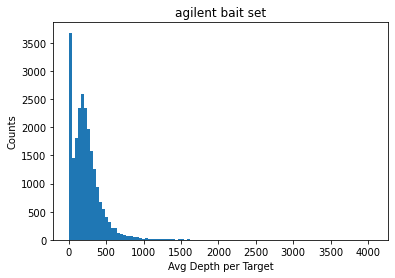

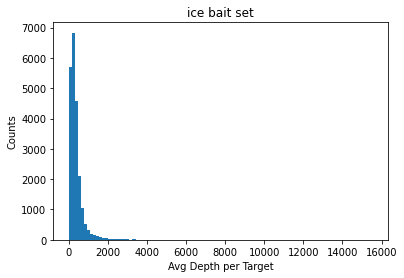

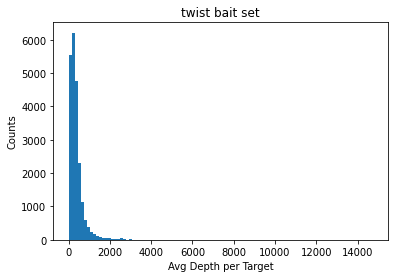

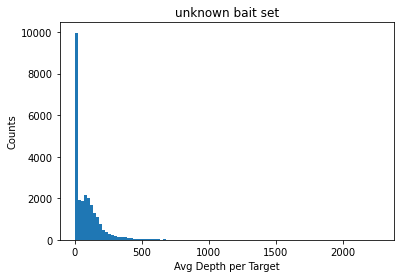

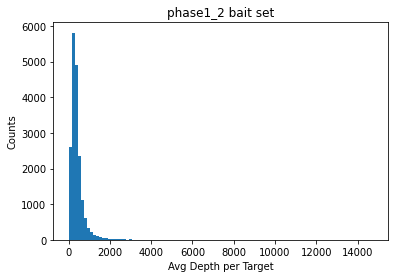

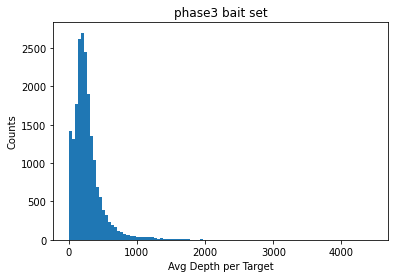

In [24]:
for name, b in all_bed.items():
    fig = plt.hist(b['depth_norm'], 100)
    plt.title(f"{name} bait set")
    plt.xlabel('Avg Depth per Target')
    plt.ylabel('Counts')
    plt.show()

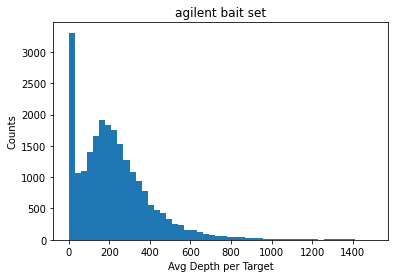

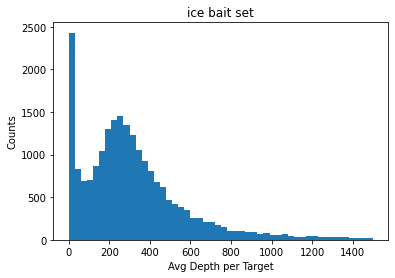

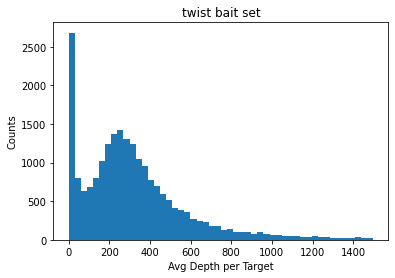

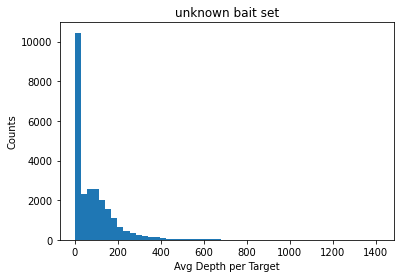

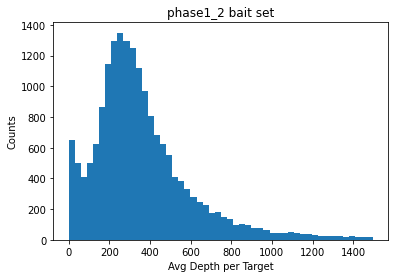

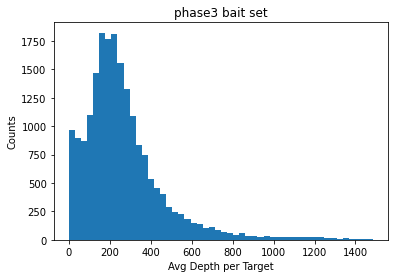

In [25]:
for name, b in all_bed.items():
    fig = plt.hist(b[b['depth_norm'] < 1500]['depth_norm'], 50)
    plt.title(f"{name} bait set")
    plt.xlabel('Avg Depth per Target')
    plt.ylabel('Counts')
    plt.show()

(0.0, 1500.0)

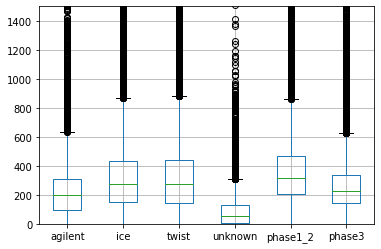

In [45]:
depth_list = []
for name, b in all_bed.items():
    depth_list.append(list(b['depth_norm']))

df = pd.DataFrame(data = depth_list, index = all_bed.keys())
df.transpose().boxplot()
ax = plt.gca()
ax.set_ylim([0,1500])

In [41]:
for name, b in all_bed.items():
    print(f'{name}: {len(b[b["depth_norm"] < 5])}')

agilent: 1273
ice: 778
twist: 862
unknown: 6840
phase1_2: 158
phase3: 194


### It seems that the Phase 1/2 consensus target file matches our WES file the best

## Now investigate bam vs. Solexa/Pond bams

In [3]:
full_bam_snp_depths = pd.read_csv('../cnv_data/NA12878_WES.vcf.depths.bed', sep='\t')
solexa_bam_snp_depths = pd.read_csv('../cnv_data/NA12878_Solexa_WES.vcf.depths.bed', sep='\t')
pond_bam_snp_depths = pd.read_csv('../cnv_data/NA12878_Pond_WES.vcf.depths.bed', sep='\t')


In [6]:
help(pd.DataFrame.merge)

Help on function merge in module pandas.core.frame:

merge(self, right: 'FrameOrSeriesUnion', how: 'str' = 'inner', on: 'IndexLabel | None' = None, left_on: 'IndexLabel | None' = None, right_on: 'IndexLabel | None' = None, left_index: 'bool' = False, right_index: 'bool' = False, sort: 'bool' = False, suffixes: 'Suffixes' = ('_x', '_y'), copy: 'bool' = True, indicator: 'bool' = False, validate: 'str | None' = None) -> 'DataFrame'
    Merge DataFrame or named Series objects with a database-style join.
    
    A named Series object is treated as a DataFrame with a single named column.
    
    The join is done on columns or indexes. If joining columns on
    columns, the DataFrame indexes *will be ignored*. Otherwise if joining indexes
    on indexes or indexes on a column or columns, the index will be passed on.
    When performing a cross merge, no column specifications to merge on are
    allowed.
    
    Parameters
    ----------
    right : DataFrame or named Series
        Object 

In [8]:
combo_depths = full_bam_snp_depths.merge(solexa_bam_snp_depths, on=['chr', 'pos'], suffixes=['_full', '_solexa']).merge(pond_bam_snp_depths, on=['chr', 'pos']).rename(columns={'depth': 'depth_pond'})

In [10]:
combo_depths.set_index(['chr', 'pos'], inplace=True)

In [18]:
combo_depths['depth_combo'] = combo_depths['depth_solexa'] + combo_depths['depth_pond']

In [66]:
combo_depths[(combo_depths['depth_combo'] - combo_depths['depth_full']) > 3]

depth_full  depth_solexa  depth_pond  depth_combo
chr  pos                                                         
chr1 790933             17            20           1           21
     866563              9            12           1           13
     873251             11             7           9           16
     873542            156           131         111          242
     873548            159           129         114          243
...                    ...           ...         ...          ...
chrX 155292770          17            20           9           29
     155491696          65            42          46           88
     155524242          12            11           6           17
     155545002          22            32           8           40
     155545046          52            60          31           91

[90625 rows x 4 columns]

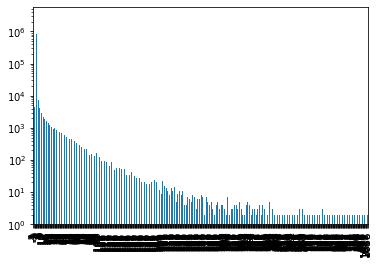

In [54]:
ax = (combo_depths['depth_combo'] - combo_depths['depth_full']).value_counts().sort_index().plot.bar(log=True)


Text(0, 0.5, 'Number of SNVs')

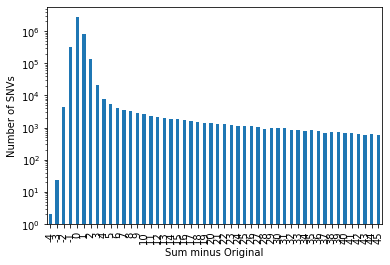

In [60]:
ax = (combo_depths['depth_combo'] - combo_depths['depth_full']).value_counts().sort_index().iloc[0:50].plot.bar(log=True)
ax.set_xlabel('Sum minus Original')
ax.set_ylabel('Number of SNVs')

In [32]:
combo_depths[combo_depths['depth_full'] > 10].describe()

,depth_full,depth_solexa,depth_pond,depth_combo
count,91543.000000,91543.000000,91543.000000,91543.000000
mean,63.095780,56.659810,40.260664,96.920475
std,75.001582,81.322035,51.693131,123.516204
min,11.000000,0.000000,0.000000,9.000000
25%,20.000000,17.000000,10.000000,28.000000
50%,41.000000,35.000000,24.000000,60.000000
75%,82.000000,71.000000,53.000000,125.000000
max,4832.000000,7218.000000,1850.000000,7282.000000


In [24]:
! samtools view -c ../cnv_data/NA12878.alt_bwamem_GRCh38DH.20150826.CEU.exome.bam

335417841


In [ ]:
! samtools view -c ../cnv_data/NA12878.alt_bwamem_GRCh38DH.20150826.CEU.exome_Pond.bam  # 91052397

In [ ]:
! samtools view -c ../cnv_data/NA12878.alt_bwamem_GRCh38DH.20150826.CEU.exome_Solexa-51024.bam  # 244365444

In [30]:
244365444 + 91052397

335417841

The two split bams (Pond and Solexa) do indeed have the correct number of reads, summing to the count for the whole bam. Why then are there certain loci that have a higher read depth? Because I used the cram to get the depths the first time. There is a bug where the cram reports different (generally lower) read depths. Not sure why, but the filtering must be different. I am re-running on the bam, and that should be totally concordant with the sum of Pond + Solexa.